In [270]:
import cartopy.crs as ccrs
import cartopy
import datetime as dt
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4
import numpy as np
import os

In [271]:
hofx_file = '/Users/afox/Jedi/Jedi_experiments/output/hofx/hofx3d_owp_snow_depth_2020030100_0000.nc'
datetime = '2020-03-01T00:00:00'
window_begin = '2020-02-29T12:00:00'
window_end = '2020-03-01T12:00:00'
metric = 'ObsValue' #'ObsValue'
field = 'snow_depth'
units = 'm'
output_path = './'
plotformat = 'png'

colmin = None
colmax = None

In [272]:
odat = []
lons = []
lats = []
time = []

# Message file being read
print(" Reading "+hofx_file)

# Open the file
fh = netCDF4.Dataset(hofx_file)

if metric=='omb':
    odat_proc = fh.groups['ObsValue'].variables[field][:] - fh.groups['hofx'].variables[field][:]
else:
    odat_proc = fh.groups[metric].variables[field][:]

# Read metadata
lons_proc = fh.groups['MetaData'].variables['longitude'][:]
lats_proc = fh.groups['MetaData'].variables['latitude'][:]
time_proc = fh.groups['MetaData'].variables['dateTime'][:]

for m in range(len(odat_proc)):
    odat.append(odat_proc[m])
    lons.append(lons_proc[m])
    lats.append(lats_proc[m])

fh.close()

 Reading /Users/afox/Jedi/Jedi_experiments/output/hofx/hofx3d_owp_snow_depth_2020030100_0000.nc


In [273]:
# Figure filename
# ---------------
field_savename = field

savename = os.path.join(output_path, field_savename+"_"+metric+"_"+datetime+"."+plotformat)

# Set missing values to nans
missing = 9.0e+30
odat = np.where(np.abs(odat) < missing, odat, float("NaN"))
   
numobs = len(odat)

obarray = np.empty([numobs, 3])

obarray[:, 0] = odat
obarray[:, 1] = lons
obarray[:, 2] = lats

# Exclude observations north of 50 degrees latitude
obarray = obarray[obarray[:,2]<50.0]

In [274]:
# Compute and print some stats for the data
# -----------------------------------------
stdev = np.nanstd(obarray[:, 0])  # Standard deviation
omean = np.nanmean(obarray[:, 0]) # Mean of the data
datmi = np.nanmin(obarray[:, 0])  # Min of the data
datma = np.nanmax(obarray[:, 0])  # Max of the data

print("Plotted data statistics: ")
print("Mean: ", omean)
print("Standard deviation: ", stdev)
print("Minimum ", datmi)
print("Maximum: ", datma)

Plotted data statistics: 
Mean:  0.5416467882472166
Standard deviation:  0.8303115964799495
Minimum  0.0
Maximum:  6.883399963378906


In [275]:
# Norm for scatter plot
# ---------------------
norm = None


# Min max for colorbar
# --------------------
if np.nanmin(obarray[:, 0]) < 0:
    cmax = datma
    cmin = datmi
    cmap = 'RdBu'
else:
    cmax = omean+stdev
    cmin = np.maximum(omean-stdev, 0.0)
    cmap = 'viridis'

if metric == 'PreQC' or metric == 'EffectiveQC':
    cmin = datmi
    cmax = datma

# Specialized colorbar for integers
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[1] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.insert(np.linspace(0.5, int(cmax)+0.5, int(cmax)+1), 0, 0)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# If using omb then use standard deviation for the cmin/cmax
if metric=='omb' or metric=='ombg' or metric=='oman':
    cmax = stdev
    cmin = -stdev

# Override with user chosen limits
if (colmin!=None):
    print("Using user provided minimum for colorbar")
    cmin = colmin
if (colmax!=None):
    print("Using user provided maximum for colorbar")
    cmax = colmax   

 Saving figure as ./snow_depth_ObsValue_2020-03-01T00:00:00.png 



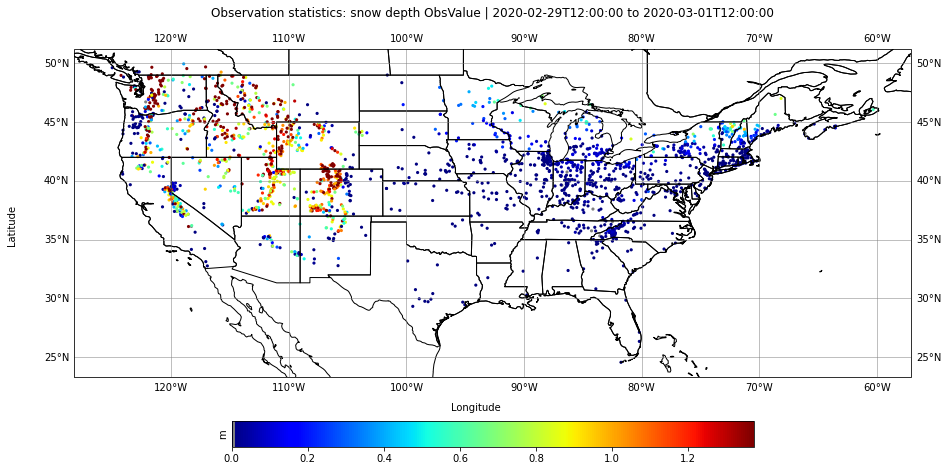

In [276]:
# Create figure
# -------------
fig = plt.figure(figsize=(15, 8))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator(
#    [-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=10, linewidth=0,
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=cmin, vmax=cmax)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
#ax.set_global()

# draw coastlines
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
            window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes,
        rotation='vertical', va='bottom')

# show plot
print(" Saving figure as", savename, "\n")
#plt.savefig(savename, facecolor='w', dpi = 400)

In [277]:
#obarray = obarray[obarray[:,2]<41.0]
#obarray = obarray[obarray[:,2]>37.0]
#obarray = obarray[obarray[:,1]<-102.0]
#obarray = obarray[obarray[:,1]>-109.4]
smallobs = obarray[:,0]<0.001
obarray[smallobs,0] = 0

 Saving figure as ./test.png 



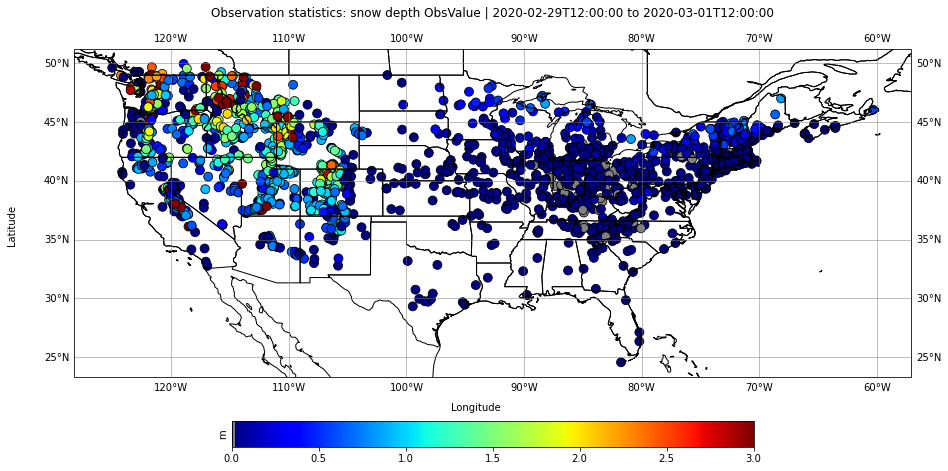

In [278]:
# Create figure
# -------------
fig = plt.figure(figsize=(15, 8))

# initialize the plot pointing to the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

# plot grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')

gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator(
#    [-180, -135, -90, -45, 0, 45, 90, 135, 179.9])
ax.set_ylabel("Latitude",  fontsize=7)
ax.set_xlabel("Longitude", fontsize=7)

ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# scatter data
sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=80, linewidth=0.8, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=3)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel(units, fontsize=10)

# plot globally
#ax.set_global()

# draw coastlines
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)

# figure labels
plt.title("Observation statistics: "+field.replace("_"," ")+" "+metric+" | "+
            window_begin+" to "+window_end, y=1.08)
ax.text(0.45, -0.1,   'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.08, 0.4, 'Latitude', transform=ax.transAxes,
        rotation='vertical', va='bottom')

# show plot
savename = './test.png'
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)

In [279]:
geom_file = "/Users/afox/Jedi/Jedi_experiments/input/wrf_hydro_nwm_files/geometry_cfs_long_range_ens.nc"
print('\nOpening ', geom_file, 'for reading')
ncfile = netCDF4.Dataset(geom_file, mode='r')
# Get metadata from the file
npx = ncfile.dimensions["west_east"].size
npy = ncfile.dimensions["south_north"].size
npz = 1
lons = ncfile.variables["XLONG"][:]
lats = ncfile.variables["XLAT"][:]
# Print field dimensions
print(" Grid dimensions", npx, 'x', npy, 'x', npz)

print('\nOpening ', geom_file, 'for reading')
ncfile = netCDF4.Dataset(geom_file, mode='r')

# Zero out array to fill with field
hgt = np.zeros((npy, npx))
hgt[:,:] = ncfile.variables["HGT"][:,:]

cmax = np.max(hgt)
cmin = np.min(hgt)
cmap_h = 'gray'
levels_h = np.linspace(cmin,cmax,50)# Create two dimensional contour plot of HGT



Opening  /Users/afox/Jedi/Jedi_experiments/input/wrf_hydro_nwm_files/geometry_cfs_long_range_ens.nc for reading
 Grid dimensions 4608 x 3840 x 1

Opening  /Users/afox/Jedi/Jedi_experiments/input/wrf_hydro_nwm_files/geometry_cfs_long_range_ens.nc for reading


In [280]:
sw = [36.5, -108.5]
ne = [41.5, -102.0]
temp = ((lats - sw[0])**2 + (lons - sw[1])**2)
idx = temp.argmin()
sw_cood = np.unravel_index(idx, temp.shape)
temp = ((lats - ne[0])**2 + (lons - ne[1])**2)
idx = temp.argmin()
ne_cood = np.unravel_index(idx, temp.shape)

In [281]:
#lons = lons[sw_cood[0]:ne_cood[0], sw_cood[1]:ne_cood[1]]
#lats = lats[sw_cood[0]:ne_cood[0], sw_cood[1]:ne_cood[1]]
#hgt = hgt[sw_cood[0]:ne_cood[0], sw_cood[1]:ne_cood[1]]

 Saving figure as ./Conus_elevation_and_Obs.png 



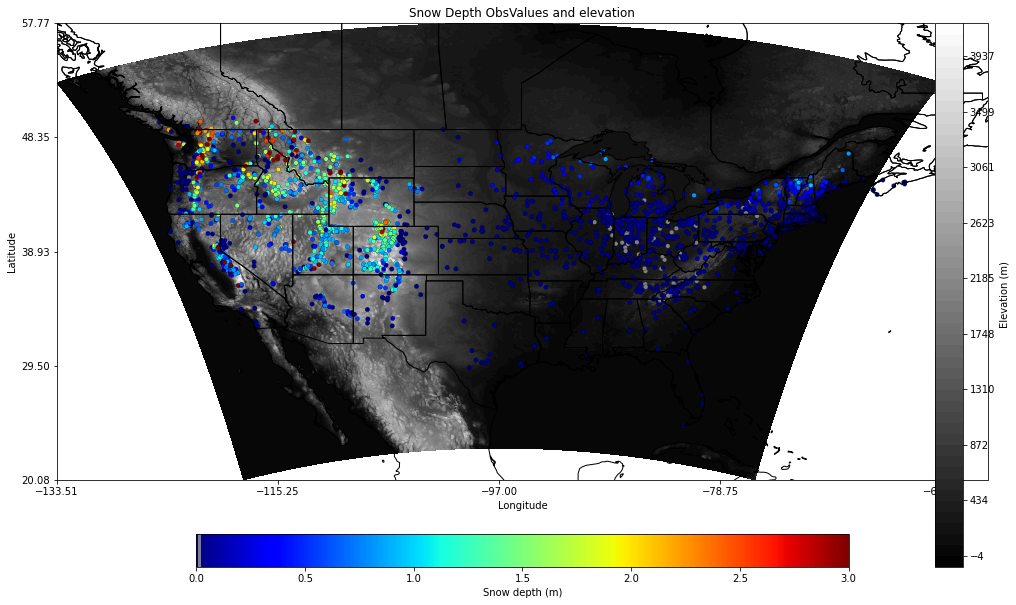

In [282]:
# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, hgt,
                     transform=projection,
                     cmap=cmap_h,
                     levels=levels_h)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=20, linewidth=0.2, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=3)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth ObsValues and elevation")
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
if not units==None:
    cbar.ax.set_ylabel("Elevation (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("Snow depth (m)", fontsize=10)

# show plot
savename = './Conus_elevation_and_Obs.png'
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)

In [283]:
field_file = "/Users/afox/Jedi/Jedi_experiments/input/wrf_hydro_nwm_files/RESTART.2020030100_DOMAIN1"

print('\nOpening ', field_file, 'for reading')
ncfile = netCDF4.Dataset(field_file, mode='r')

# Zero out array to fill with field
fld = np.zeros((npy, npx))
fld[:,:] = ncfile.variables["SNOWH"][:,:]

cmin = 0 #np.max(fld)
cmax = 3 #np.min(fld)
levels = np.linspace(cmin,cmax,50)# Create two dimensional contour plot of HGT

#fld = fld[sw_cood[0]:ne_cood[0], sw_cood[1]:ne_cood[1]]


Opening  /Users/afox/Jedi/Jedi_experiments/input/wrf_hydro_nwm_files/RESTART.2020030100_DOMAIN1 for reading


 Saving figure as ./Conus_Bkg_and_Obs.png 



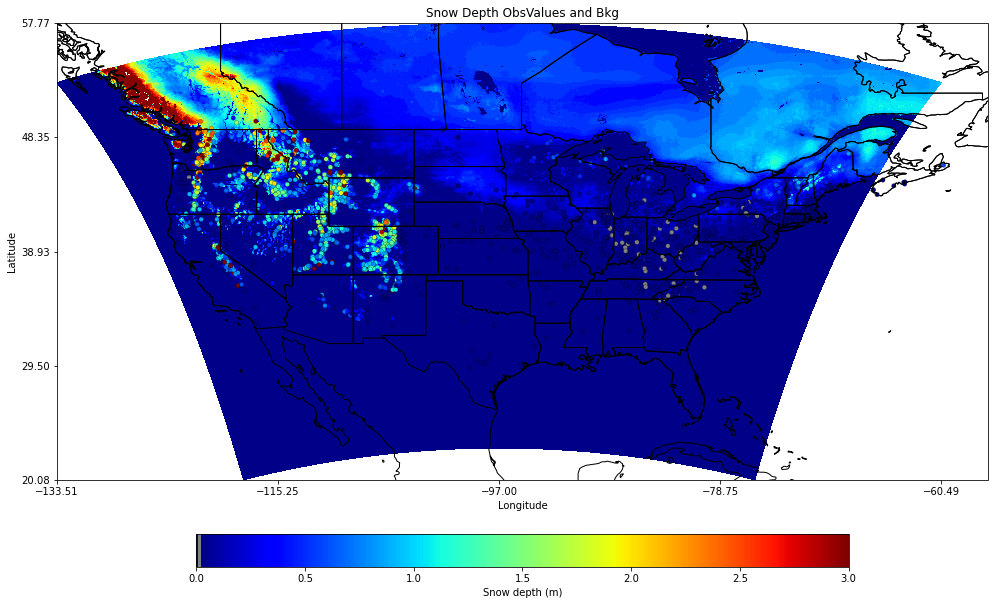

In [284]:
# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, fld,
                     transform=projection,
                     cmap=cmap,
                     levels=levels)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=20, linewidth=0.2, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=3)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth ObsValues and Bkg")
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
#cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
#if not units==None:
#    cbar.ax.set_ylabel("Bkg Snow depth (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("Snow depth (m)", fontsize=10)

# show plot
savename = './Conus_Bkg_and_Obs.png'
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)

In [285]:
field_file = "/Users/afox/Jedi/Jedi_experiments/output/letkf/conus/letkf.lsm.ens.0.2020-03-01T00:00:00Z.PT0S"

print('\nOpening ', field_file, 'for reading')
ncfile = netCDF4.Dataset(field_file, mode='r')

# Zero out array to fill with field
fld = np.zeros((npy, npx))
fld[:,:] = ncfile.variables["SNOWH"][:,:]

cmin = 0 #np.max(fld)
cmax = 3 #np.min(fld)
levels = np.linspace(cmin,cmax,50)# Create two dimensional contour plot of HGT

#fld = fld[sw_cood[0]:ne_cood[0], sw_cood[1]:ne_cood[1]]
fld[fld<0.0] = 0


Opening  /Users/afox/Jedi/Jedi_experiments/output/letkf/conus/letkf.lsm.ens.0.2020-03-01T00:00:00Z.PT0S for reading


 Saving figure as ./Conus_Ana_and_Obs.png 



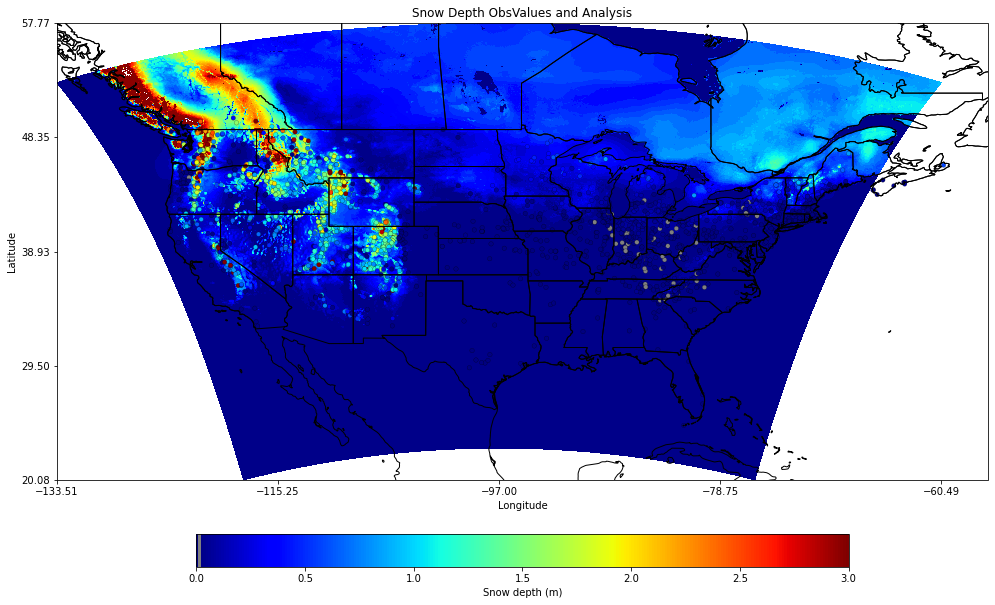

In [286]:
# Create two dimensional contour plot of HGT

# Set the projection
projection = ccrs.PlateCarree()

# Create figure to hold plot
fig = plt.figure(figsize=(20, 10))

# Just one subplot for now
ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Contour the field
im = ax.contourf(lons, lats, fld,
                     transform=projection,
                     cmap=cmap,
                     levels=levels)

sc = ax.scatter(obarray[:, 1], obarray[:, 2],
                c=obarray[:, 0], s=20, linewidth=0.2, edgecolors='black',
                transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=3)

# Add coast lines to the plot
ax.coastlines()

ax.add_feature(cartopy.feature.STATES)

# Add labels to the plot
ax.set_xticks(np.linspace(np.min(lons), np.max(lons), 5), crs=projection)
ax.set_yticks(np.linspace(np.min(lats), np.max(lats), 5), crs=projection)

ax.set_xlabel("Longitude")
ax.set_ylabel('Latitude')
ax.set_title("Snow Depth ObsValues and Analysis")
#ax.set_global()

# Add a colorbar for the filled contour.
# colorbar
#cbar = plt.colorbar(im, ax=ax, pad=-0.2, fraction=0.06,)
#if not units==None:
#    cbar.ax.set_ylabel("Bkg Snow depth (m)", fontsize=10)

# colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=.1, fraction=0.06,)
if not units==None:
    cbar.ax.set_xlabel("Snow depth (m)", fontsize=10)

# show plot
savename = './Conus_Ana_and_Obs.png'
print(" Saving figure as", savename, "\n")
plt.savefig(savename, facecolor='w', dpi = 400)